In [8]:
import pandas as pd, datetime as dt, matplotlib.pyplot as plt, numpy as np, streamlit as st, os, sys, nest_asyncio
import py_vollib_vectorized

from py_vollib.black_scholes.implied_volatility import implied_volatility
from py_vollib.black_scholes.greeks.analytical import delta

import datetime
%matplotlib inline 

In [2]:
# importing functions from the code base
base_path = os.path.abspath(os.path.join('..'))
print(base_path)
if base_path not in sys.path:
    sys.path.append(base_path)
    
import src.api as api

/Users/marcfiani/Documents/projects/active/crypto_option_dashboard


***
## 1) Enter Inputs

In [3]:
underlying = "BTC"  # Values can be 'BTC' or 'ETH'
desired_option_type = "Call"  # Values can be 'Call' or 'Put'

***
## 2) Identify the month-end option of the correct type for the chosen underlying

In [4]:
nest_asyncio.apply()
instruments = api.get_instruments(currency=underlying, kind="option", expired=False)
instruments.head(2)

,tick_size,taker_commission,strike,settlement_period,settlement_currency,quote_currency,option_type,min_trade_amount,maker_commission,kind,is_active,instrument_name,expiration_timestamp,creation_timestamp,counter_currency,contract_size,block_trade_commission,base_currency,creation_time,expiration_time
0,0.0005,0.0003,30000.0,month,BTC,BTC,call,0.1,0.0003,option,True,BTC-24JUN22-30000-C,1656057600000,1627994072000,USD,1.0,0.00015,BTC,2021-08-03 07:34:32,2022-06-24 03:00:00
1,0.0005,0.0003,45000.0,month,BTC,BTC,put,0.1,0.0003,option,True,BTC-25MAR22-45000-P,1648195200000,1628197380000,USD,1.0,0.00015,BTC,2021-08-05 16:03:00,2022-03-25 03:00:00


#### 2)a) Identify what month we will be on in 3 days time

In [14]:
desired_month = (dt.datetime.now() + dt.timedelta(days=3)).month
datetime_object = datetime.datetime.strptime(str(desired_month), "%m")
month_name = datetime_object.strftime("%B")

print("In 3 days time we will be in month " + month_name)

In 3 days time we will be in month March


#### 2)b) Get the last expiry for that month  (that expiry will be on the last Friday of the month)

In [23]:
# Get the last option expiring on that month
expiry_dates = instruments.expiration_time.unique()
expiry_months = expiry_dates.astype('datetime64[M]').astype(int) % 12 + 1

month_end_expiry = np.datetime64(dt.datetime.now())

for i in range(0, len(expiry_dates)):
    if expiry_months[i] == desired_month and expiry_dates[i] > month_end_expiry:
        month_end_expiry =  expiry_dates[i]

print(month_end_expiry)

2022-03-25T03:00:00.000000000


#### 2)c) Get current spot (there are much better ways to do this)

In [24]:
temp = dt.datetime.now()
today_dt = dt.datetime(year=temp.year, month=temp.month, day=temp.day, hour=temp.hour, minute=temp.minute)

ts_today = today_dt.timestamp() * 1000
spot_ohlcv = api.get_historical_data(ts_today, ts_today, underlying + "-PERPETUAL", "1D")

spot = (spot_ohlcv['open'][0] + spot_ohlcv['close'][0] + spot_ohlcv['high'][0] + spot_ohlcv['low'][0]) / 4

print(spot)

44280.0


#### 2)d) Find the closest strike from the current spot among the ones available

In [26]:
desired_option_type = desired_option_type.lower()

strikes = instruments.loc[instruments['expiration_time'] == month_end_expiry].loc[instruments['option_type'] == desired_option_type].strike.unique()
desired_strike = min(strikes, key=lambda x:abs(x-spot))

print(desired_strike)

45000.0


#### 2)e) Isolate the data related to the option we are looking to backtest

In [27]:
instrument_data = instruments.loc[(instruments.expiration_time == month_end_expiry) 
                                  & (instruments.option_type == desired_option_type) 
                                  & (instruments.strike == desired_strike)]

instrument_data

,tick_size,taker_commission,strike,settlement_period,settlement_currency,quote_currency,option_type,min_trade_amount,maker_commission,kind,is_active,instrument_name,expiration_timestamp,creation_timestamp,counter_currency,contract_size,block_trade_commission,base_currency,creation_time,expiration_time
63,0.0005,0.0003,45000.0,month,BTC,BTC,call,0.1,0.0003,option,True,BTC-25MAR22-45000-C,1648195200000,1628197380000,USD,1.0,0.00015,BTC,2021-08-05 16:03:00,2022-03-25 03:00:00


***
## 3) Fetch Historical Data from the Deribit API

#### 3)a) Get data of both spot and option historical levels

In [28]:
ts_creation = dt.datetime.fromtimestamp(instrument_data["creation_timestamp"].values[0]/1000).replace(second = 0, microsecond = 0).timestamp() * 1000
ts_expiration = dt.datetime.fromtimestamp(instrument_data["expiration_timestamp"].values[0]/1000).replace(second = 0, microsecond = 0).timestamp() * 1000

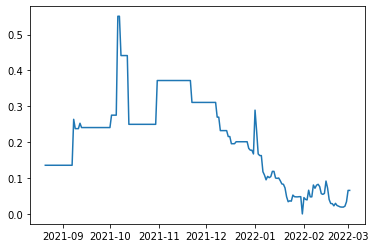

In [29]:
time_period = '1D'
option_data = api.get_historical_data(ts_creation,
                                      ts_expiration,
                                      instrument_data["instrument_name"].iloc[0],
                                      time_period)
plt.plot(option_data['timestamp'], option_data['close'])

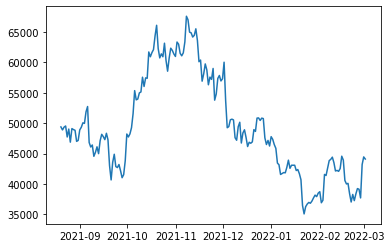

In [30]:
# For BTC the underlying will be 'BTC-PERPETUAL' while for ETH it will be 'ETH-PERPETUAL'
spot_data = api.get_historical_data(option_data.timestamp[0].timestamp() * 1000,
                                    ts_expiration,
                                    underlying + "-PERPETUAL",
                                    time_period)
plt.plot(spot_data['timestamp'], spot_data['close'])

#### 3)b) Combine option and spot data together in a dataframe

In [31]:
data = pd.merge(option_data,spot_data,how="left",on="ticks",suffixes=("_option","_spot"))

unwanted = data.columns[data.columns.str.startswith('Unnamed')]
data.drop(unwanted, axis=1, inplace=True)
data.drop(["timestamp_option","timestamp_spot"],axis=1, inplace=True)
data['timestamp'] = data.ticks.apply(lambda x:dt.datetime.fromtimestamp(x/1000))

In [32]:
# Express the price of the option in USD
data['close_option'] = data.apply(lambda row: (row['close_option'] * row['close_spot']), axis=1)

#### 3)c) Set parameters for backtest

In [33]:
strike = desired_strike

if desired_option_type == 'call':
    option_type = 'c'
else:
    option_type = 'p'
expiry = month_end_expiry
r = 0.01 # This is the risk-free interest rate. For short-dated options it doesn't matter much
qty = 1
mult = 1
is_delta_hedged = True

data["time_to_expiry"] = data.timestamp.apply(lambda x:expiry-x)
data["days_to_expiry"] = data["time_to_expiry"].apply(lambda x: x.days)

***
## 4) Backtest

#### 4)a) Implied Volatility

/Users/marcfiani/Documents/projects/active/crypto_option_dashboard/venv/lib/python3.9/site-packages/py_vollib_vectorized/implied_volatility.py:75: UserWarning: Found Below Intrinsic contracts at index [15, 16, 55, 56, 57, 58, 59, 60, 61, 62, 63, 64, 65, 66, 68, 69, 70]
  below_intrinsic, above_max_price = _check_below_and_above_intrinsic(K, F, flag, undiscounted_option_price, on_error)


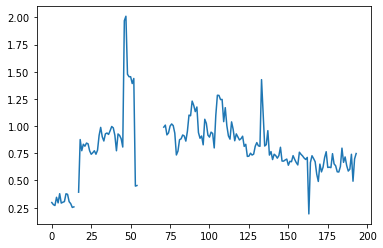

In [34]:
data['ivol_mid'] = implied_volatility(price=data['close_option'],
                                      S=data['close_spot'],
                                      K=strike,
                                      t=data['days_to_expiry']/365,
                                      r=r,
                                      flag=option_type, 
                                      return_as="series")
plt.plot(data['ivol_mid'])

#### 4)b) Delta

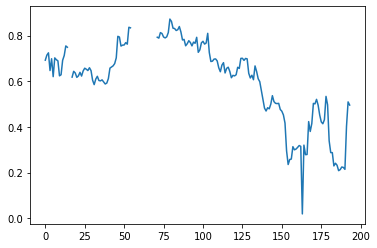

In [36]:
data['delta_mid'] = py_vollib_vectorized.greeks.delta(option_type, data['close_spot'], 
        strike,data['days_to_expiry']/365, r, data[ 'ivol_mid'])
plt.plot(data['delta_mid'])

#### 4)c) PnL

In [37]:
data['daily_pnl_option'] = data['close_option'].diff() * qty * mult
data["daily_pnl_spot"] = data['close_spot'].diff() * data['delta_mid'].shift() * qty * mult
ts = data['daily_pnl_option'] - data["daily_pnl_spot"] * is_delta_hedged
data['pnl'] = ts.cumsum()

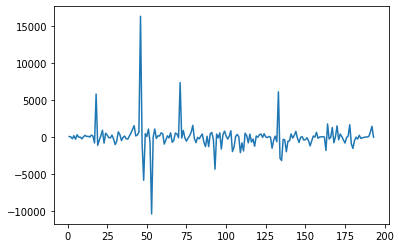

In [38]:
plt.plot(data['daily_pnl_option'])

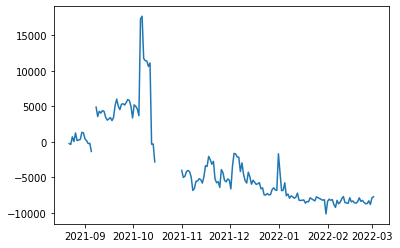

In [42]:
plt.plot(data['timestamp'],data['pnl']);

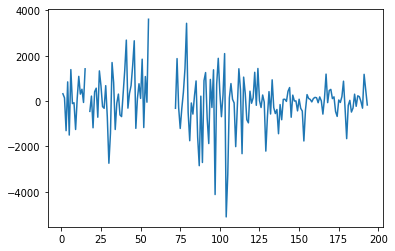

In [39]:
plt.plot(data["daily_pnl_spot"])